<a href="https://colab.research.google.com/github/zshahid91/GA-with-SHAP-XAI/blob/main/Experiments_SHAP_GA_AI_Rota_Scheduling_July2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functions for the Scheduling GA

In [ ]:
import math
import random
from typing import List, Tuple, Dict

# ─── PROBLEM DEFINITION ────────────────────────────────────────────────────────

Staff = List[str]
Shift = List[str]
Demand = List[Dict[str, int]]


class RosterProblem:
    def __init__(self,
                 staff: Staff,
                 shifts: Shift,
                 demand: Demand,
                 max_shifts_per_week: int = 5,
                 min_rest_between: int = 1):
        self.staff = staff
        self.shifts = shifts
        self.demand = demand
        self.num_staff = len(staff)
        self.num_days = len(demand)
        self.max_shifts_per_week = max_shifts_per_week
        self.min_rest_between = min_rest_between


# ─── GENOTYPE / PHENOTYPE ───────────────────────────────────────────────────────

def decode(chrom: List[int], prob: RosterProblem) -> List[List[str]]:
    sched = []
    for i in range(prob.num_staff):
        row = []
        for d in range(prob.num_days):
            gene = chrom[i * prob.num_days + d]
            row.append(prob.shifts[gene])
        sched.append(row)
    return sched


# ─── FITNESS ───────────────────────────────────────────────────────────────────

def fitness(chrom: List[int], prob: RosterProblem) -> float:
    sched = decode(chrom, prob)
    penalty = 0.0

    for d in range(prob.num_days):
        counts = {s: 0 for s in prob.shifts}
        for i in range(prob.num_staff):
            counts[sched[i][d]] += 1
        for s in prob.shifts[1:]:  # skip "Off"
            req = prob.demand[d].get(s, 0)
            if counts[s] < req:
                penalty += 1000 * (req - counts[s])
            elif counts[s] > req:
                penalty += 100 * (counts[s] - req)

    for i in range(prob.num_staff):
        workdays = sum(1 for d in range(prob.num_days) if sched[i][d] != "Off")
        if workdays > prob.max_shifts_per_week:
            penalty += 50 * (workdays - prob.max_shifts_per_week)

    for i in range(prob.num_staff):
        for d in range(prob.num_days - 1):
            if sched[i][d] == "Night" and sched[i][d + 1] != "Off":
                penalty += 20

    return penalty


# ─── SIMULATED ANNEALING ───────────────────────────────────────────────────────

def simulated_annealing(chrom: List[int],
                        prob: RosterProblem,
                        T_init: float = 100.0,
                        T_min: float = 1e-3,
                        alpha: float = 0.95,
                        max_iter: int = 200) -> List[int]:
    current = chrom.copy()
    current_fit = fitness(current, prob)
    T = T_init

    for _ in range(max_iter):
        neighbor = current.copy()
        idx = random.randrange(len(current))
        neighbor[idx] = random.randrange(len(prob.shifts))
        neighbor_fit = fitness(neighbor, prob)

        delta = neighbor_fit - current_fit
        if delta < 0 or random.random() < math.exp(-delta / T):
            current = neighbor
            current_fit = neighbor_fit
        T *= alpha
        if T < T_min:
            break

    return current


# ─── GENETIC ALGORITHM OPERATORS ───────────────────────────────────────────────

def random_chrom(prob: RosterProblem) -> List[int]:
    return [random.randrange(len(prob.shifts)) for _ in range(prob.num_staff * prob.num_days)]


def tournament_selection(pop: List[List[int]], fits: List[float], k=3) -> List[int]:
    best = None
    best_fit = float('inf')
    for _ in range(k):
        i = random.randrange(len(pop))
        if fits[i] < best_fit:
            best_fit, best = fits[i], pop[i]
    return best.copy()


def crossover(a: List[int], b: List[int], cx_rate=0.8) -> Tuple[List[int], List[int]]:
    if random.random() > cx_rate:
        return a.copy(), b.copy()
    point = random.randrange(1, len(a))
    return a[:point] + b[point:], b[:point] + a[point:]


def mutate(chrom: List[int], prob: RosterProblem, mut_rate=0.1) -> None:
    for idx in range(len(chrom)):
        if random.random() < mut_rate:
            chrom[idx] = random.randrange(len(prob.shifts))


# ─── MAIN GA LOOP ──────────────────────────────────────────────────────────────

def run_ga(prob: RosterProblem,
           pop_size=50,
           generations=200) -> Tuple[List[int], float]:
    pop = [random_chrom(prob) for _ in range(pop_size)]
    best_chrom, best_fit = None, float('inf')

    for gen in range(generations):
        fits = [fitness(c, prob) for c in pop]
        for c, f in zip(pop, fits):
            if f < best_fit:
                best_fit, best_chrom = f, c.copy()

        # Apply SA to top 5 individuals
        top_indices = sorted(range(len(fits)), key=lambda i: fits[i])[:5]
        for i in top_indices:
            improved = simulated_annealing(pop[i], prob)
            improved_fit = fitness(improved, prob)
            if improved_fit < fits[i]:
                pop[i] = improved
                fits[i] = improved_fit

        newpop = []
        while len(newpop) < pop_size:
            p1 = tournament_selection(pop, fits)
            p2 = tournament_selection(pop, fits)
            c1, c2 = crossover(p1, p2)
            mutate(c1, prob)
            mutate(c2, prob)
            newpop.extend([c1, c2])
        pop = newpop[:pop_size]

    return best_chrom, best_fit

In [ ]:
# ─── DEMO USE ──────────────────────────────────────────────────────────────────

staff = ["Alice", "Bob", "Cara", "Dave", "Eve", "Frank", "Gina"]
shifts = ["Off", "Morning", "Afternoon", "Night"]
demand = [ # Demand for 7 days
        {"Morning": 2, "Afternoon": 2, "Night": 1},
        {"Morning": 3, "Afternoon": 2, "Night": 2},
        {"Morning": 2, "Afternoon": 3, "Night": 1},
        {"Morning": 2, "Afternoon": 2, "Night": 2},
        {"Morning": 3, "Afternoon": 3, "Night": 1},
        {"Morning": 1, "Afternoon": 1, "Night": 1},
        {"Morning": 1, "Afternoon": 1, "Night": 1},
    ]


prob = RosterProblem(staff, shifts, demand)

best_chrom, score = run_ga(prob, pop_size=100, generations=300)
sched = decode(best_chrom, prob)

# print as simple table
print("\nFinal Weekly Schedule:")
print("Staff   " + "  ".join([f"Day{d+1}" for d in range(7)]))
for name, row in zip(staff, sched):
    print(f"{name:6s} " + "  ".join(s[0] for s in row))  # M/A/N/O
print(f"\nFinal fitness score: {score:.1f}")
print("Note: Lower fitness score indicates a better schedule.")
print("This schedule minimizes staff workload and meets demand requirements.")


Final Weekly Schedule:
Staff   Day1  Day2  Day3  Day4  Day5  Day6  Day7
Alice  O  N  N  A  A  N  M
Bob    M  M  A  N  M  O  O
Cara   M  M  O  M  A  A  O
Dave   A  M  A  A  M  O  O
Eve    N  A  M  N  A  O  O
Frank  O  A  A  O  M  M  N
Gina   A  N  M  M  N  O  A

Final fitness score: 240.0
Note: Lower fitness score indicates a better schedule.
This schedule minimizes staff workload and meets demand requirements.


# SHAP Explainer

In [ ]:
def get_feature_names(prob: RosterProblem) -> List[str]:
    feature_names = []
    for i in range(prob.num_staff):
        for d in range(prob.num_days):
            feature_names.append(f"{prob.staff[i]}_Day_{d+1}")
    return feature_names

# In your main execution block:
# feature_names = get_feature_names(prob)

In [ ]:
import numpy as np
import shap

# Assuming prob is an instance of RosterProblem configured as in your script

def fitness_for_shap(chroms: np.ndarray, prob: RosterProblem) -> np.ndarray:
    """
    Wrapper for the fitness function to be compatible with SHAP.
    Takes a 2D numpy array of chromosomes and returns a 1D numpy array of fitness scores.
    """
    scores = []
    for chrom_arr in chroms:
        # Convert numpy array back to list for your fitness function if needed
        scores.append(fitness(list(chrom_arr), prob))
    return np.array(scores)

# Example usage later:
# shap_predict_func = lambda x: fitness_for_shap(x, prob)

In [ ]:
# --- SHAP Explainability ---
# 1. Prepare SHAP components
shap_predict_func = lambda x: fitness_for_shap(x, prob)
feature_names = get_feature_names(prob)

# Generate background data - a random sample of chromosomes
num_background_samples = 100 # A larger sample often gives better approximation
background_data_chroms = [random_chrom(prob) for _ in range(num_background_samples)]
background_data_np = np.array(background_data_chroms)

# 2. Initialize SHAP Explainer
explainer = shap.KernelExplainer(shap_predict_func, background_data_np)

# 3. Calculate SHAP values for the best schedule
# Reshape best_chrom to be 2D for explainer.shap_values
best_chrom_np = np.array([best_chrom])
shap_values = explainer.shap_values(best_chrom_np)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print(shap_values)

[[    0.             0.             0.             0.
  -1146.24323575     0.             0.             0.
      0.         -1373.82361422     0.         -1409.09898877
      0.             0.             0.             0.
      0.             0.         -1179.59583084     0.
      0.         -1149.46322788 -1204.80040283 -1386.49811648
      0.         -1234.56734304     0.             0.
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.         -1442.49249098     0.         -1145.91674921
      0.             0.             0.             0.
      0.             0.             0.             0.
      0.        ]]


In [ ]:
# 4. Visualize SHAP values (optional, for debugging/initial insights)
shap.initjs() # For JS plots in notebooks
shap.force_plot(explainer.expected_value, shap_values[0], best_chrom_np[0], feature_names=feature_names)

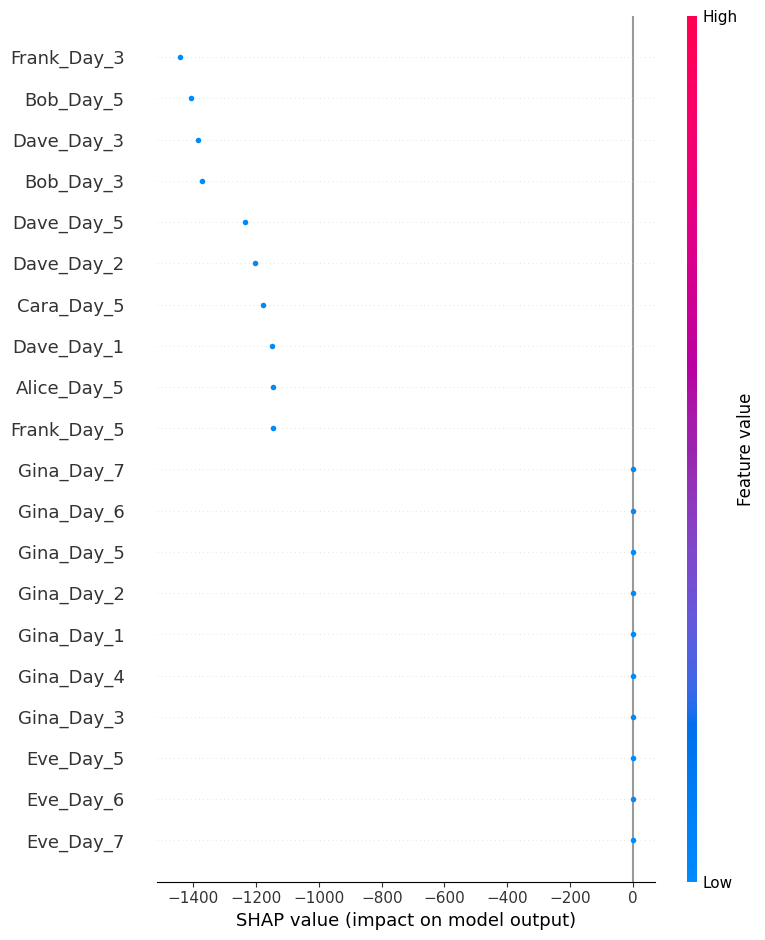

In [ ]:
shap.summary_plot(shap_values, best_chrom_np, feature_names=feature_names)

In [ ]:
def explain_schedule_in_natural_language(
    chrom: List[int],
    prob: RosterProblem,
    shap_values: np.ndarray, # 1D array for a single explanation
    expected_value: float # The baseline (average) penalty from SHAP
):
    schedule = decode(chrom, prob)
    current_fitness = fitness(chrom, prob)
    feature_names = get_feature_names(prob)

    print(f"\n--- Explanation for Schedule (Fitness: {current_fitness:.1f}) ---")
    print(f"Baseline (average) penalty across schedules: {expected_value:.1f}\n")

    # Sort features by absolute SHAP value for most impactful explanations first
    sorted_features_indices = np.argsort(np.abs(shap_values))[::-1]

    significant_contributions = []

    for i_feat in sorted_features_indices:
        feature_name = feature_names[i_feat]
        shap_value = shap_values[i_feat]

        # Extract staff index and day index from feature_name
        parts = feature_name.split('_')
        staff_name = parts[0]
        day_idx = int(parts[2]) - 1 # Day 1 -> index 0

        assigned_shift_index = chrom[i_feat]
        assigned_shift_name = prob.shifts[assigned_shift_index]

        if abs(shap_value) < 0.01: # Threshold for "insignificant" contributions
            continue

        contribution_type = "increased" if shap_value > 0 else "decreased"
        impact_level = ""
        if abs(shap_value) > 100: impact_level = "significantly "
        elif abs(shap_value) > 20: impact_level = "moderately "

        explanation = f"- The assignment of '{assigned_shift_name}' to {staff_name} on Day {day_idx+1} {impact_level}{contribution_type} the total penalty by {abs(shap_value):.1f} points."

        # Add specific context based on penalties:
        # Check for Max Shifts Per Week Penalty
        staff_idx = prob.staff.index(staff_name)
        workdays = sum(1 for d in range(prob.num_days) if schedule[staff_idx][d] != "Off")
        if workdays > prob.max_shifts_per_week and f"{staff_name}_Day_" in feature_name and assigned_shift_name != "Off":
            explanation += f" This is partly due to {staff_name} working {workdays} shifts this week (exceeding the max of {prob.max_shifts_per_week})."

        # Check for Night Shift Rest Penalty
        if assigned_shift_name == "Night" and day_idx < prob.num_days - 1 and schedule[staff_idx][day_idx + 1] != "Off":
            explanation += f" This assignment resulted in insufficient rest for {staff_name} after a night shift."

        # Check for Demand Mismatch (this is harder to pinpoint to one feature, needs aggregate view)
        # For simplicity, we can state it generally if the SHAP value is large and positive
        if shap_value > 50 and assigned_shift_name != "Off": # High positive contribution might indicate a demand issue
             # Check specific demand counts for the day and shift
            counts_on_day = {s: 0 for s in prob.shifts}
            for s_idx in range(prob.num_staff):
                counts_on_day[schedule[s_idx][day_idx]] += 1

            # Check demand for this specific shift type
            required_for_shift = prob.demand[day_idx].get(assigned_shift_name, 0)
            actual_for_shift = counts_on_day[assigned_shift_name]

            if required_for_shift > 0 and actual_for_shift < required_for_shift:
                explanation += f" It contributed to understaffing for '{assigned_shift_name}' shifts on Day {day_idx+1} (Demand: {required_for_shift}, Actual: {actual_for_shift})."
            elif actual_for_shift > required_for_shift and required_for_shift > 0:
                 explanation += f" It contributed to overstaffing for '{assigned_shift_name}' shifts on Day {day_idx+1} (Demand: {required_for_shift}, Actual: {actual_for_shift})."


        significant_contributions.append(explanation)

    if not significant_contributions:
        print("This schedule has very low penalties, and all individual contributions are minor or balanced.")
    else:
        for ex in significant_contributions:
            print(ex)

    print("\n--- Summary of overall penalty drivers ---")
    if current_fitness > expected_value:
        print(f"The schedule's penalty ({current_fitness:.1f}) is higher than average ({expected_value:.1f}).")
        print("Key features contributing to this higher penalty are detailed above (positive SHAP values).")
    else:
        print(f"The schedule's penalty ({current_fitness:.1f}) is lower than average ({expected_value:.1f}).")
        print("Key features contributing to this lower penalty are detailed above (negative SHAP values, or positive for penalty reduction).")

    # To understand overall influences from a global perspective, you'd use shap.summary_plot
    # which summarizes contributions across many schedules.
    # For example, "The 'Morning' shift on 'Day 2' is generally a major driver of penalties,
    # especially when staffing levels don't meet demand."

In [ ]:
explain_schedule_in_natural_language(best_chrom, prob, shap_values[0], explainer.expected_value)


--- Explanation for Schedule (Fitness: 240.0) ---
Baseline (average) penalty across schedules: 12912.5

- The assignment of 'Afternoon' to Frank on Day 3 significantly decreased the total penalty by 1442.5 points.
- The assignment of 'Morning' to Bob on Day 5 significantly decreased the total penalty by 1409.1 points.
- The assignment of 'Afternoon' to Dave on Day 3 significantly decreased the total penalty by 1386.5 points.
- The assignment of 'Afternoon' to Bob on Day 3 significantly decreased the total penalty by 1373.8 points.
- The assignment of 'Morning' to Dave on Day 5 significantly decreased the total penalty by 1234.6 points.
- The assignment of 'Morning' to Dave on Day 2 significantly decreased the total penalty by 1204.8 points.
- The assignment of 'Afternoon' to Cara on Day 5 significantly decreased the total penalty by 1179.6 points.
- The assignment of 'Afternoon' to Dave on Day 1 significantly decreased the total penalty by 1149.5 points.
- The assignment of 'Afternoon